In [1]:
#!pip install import-ipynb
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/Othercomputers/My Laptop/ECGR4106_Final-Project'
#import import_ipynb
#import project_models

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Othercomputers/My Laptop/ECGR4106_Final-Project


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import cuda
import math
import time
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
#check if GPU is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using GPU: ", cuda.get_device_name())

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Using GPU:  NVIDIA A100-SXM4-40GB
Fri May 10 02:49:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              45W / 400W |      5MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+---------------------------------

In [4]:
class NetworkTrafficDataset(Dataset):
    def __init__(self, features, labels):
        """
        Initialize data
        """
        # Ensure all data are of type float32 for features and int for labels when converting to tensors
        self.features = torch.tensor(features.astype('float32').values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.long)

    def __len__(self):
        """
        Total number of samples
        """
        return len(self.features)

    def __getitem__(self, idx):
        """
        Fetch one sample
        """
        return self.features[idx], self.labels[idx]

def prepare_data(csv_file_path):
    # Load the dataset
    data = pd.read_csv(csv_file_path)

    # Trim spaces from column names
    data.columns = data.columns.str.strip()

    class_counts = data['Label'].value_counts()
    total_samples = len(data)

    # Drop the index column
    data.drop(columns=['Index', 'Flow ID'], inplace=True)  # Also dropping 'Flow ID'

    # Convert Timestamp to a more useful feature, like hour of the day
    data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
    data['Hour'] = data['Timestamp'].dt.hour
    data.drop(columns=['Timestamp'], inplace=True)

    # Check for and handle inf/NaN values
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.fillna(method='ffill', inplace=True)  # Forward fill to preserve data distribution

    # Label Encoding for categorical data
    categorical_columns = ['Source IP', 'Destination IP', 'Protocol']
    category_encoder = {col: LabelEncoder() for col in categorical_columns}
    for col in categorical_columns:
        data[col] = category_encoder[col].fit_transform(data[col])

    # Normalize numeric features
    numeric_columns = data.select_dtypes(include=['float64', 'int64', 'int32', 'float32']).columns
    scaler = StandardScaler()
    data[numeric_columns] = scaler.fit_transform(data[numeric_columns].astype(float))

    # Label is treated separately
    label_encoder = LabelEncoder()
    data['Label'] = label_encoder.fit_transform(data['Label'])

    # Prepare features and labels
    labels = data['Label']
    features = data.drop(columns=['Label'])

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test, total_samples, class_counts, label_encoder

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        # Create a positional encoding matrix with shape [1, max_len, d_model]
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)  # Change shape to [max_len, 1, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        #print("After Positional Encoding - Tensor Shape:", x.shape)
        x = x + self.pe[:x.size(1), :]
        return x

class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_classes, num_layers, dropout, activation):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=d_model * 4, dropout=dropout, activation=activation, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc_out = nn.Linear(d_model, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        #print("Input Shape:", src.shape)
        src = self.embedding(src)
        src = src.unsqueeze(1)  # src shape: [batch_size, 1, d_model]
        #print("After Embedding - Tensor Shape:", src.shape)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        #print("After Transformer Encoder - Tensor Shape:", output.shape)
        output = output.mean(dim=1)
        #print("After Mean Reduction - Tensor Shape:", output.shape)
        output = self.dropout(output)
        output = self.fc_out(output)
        #print("Final Output Shape:", output.shape)
        return output

In [6]:
def train_model(model, train_loader, val_loader, optimizer, train_criterion, val_criterion, epochs):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = train_criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Validation phase
        model.eval()  # Set model to evaluate mode
        val_running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = val_criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                correct_preds += (torch.sum(preds == labels.data)).item()
                total_preds += labels.size(0)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        # Compute and store validation accuracy as a float
        val_accuracy = 100 * correct_preds / total_preds
        val_accuracies.append(val_accuracy)

        #if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    return model, train_losses, val_losses, val_accuracies

In [7]:
def plot_metrics(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plotting training and validation loss on the first y-axis
    ax1.plot(epochs, train_losses, 'b-o', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-o', label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.tick_params(axis='y')
    ax1.legend(loc='upper left')

    # Creating a second y-axis for validation accuracy
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.plot(epochs, val_accuracies, 'g-s', label='Validation Accuracy')
    ax2.set_ylabel('Accuracy (%)')
    ax2.tick_params(axis='y')
    ax2.legend(loc='upper right')

    # Title and show
    plt.title('Training/Validation Loss and Validation Accuracy')
    plt.show()

def detailed_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())  # Collect all predictions
            all_labels.extend(labels.cpu().numpy())  # Collect all labels

    # Decode the labels to their original names using LabelEncoder
    predicted_labels = label_encoder.inverse_transform(all_preds)
    actual_labels = label_encoder.inverse_transform(all_labels)

    # Print classification report
    print(classification_report(actual_labels, predicted_labels))

    # Generate and plot confusion matrix
    cm = confusion_matrix(actual_labels, predicted_labels, labels=label_encoder.classes_)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [8]:
# Setting parameters
batch_size = 4096

d_model = 256  # Size of the embeddings

nhead = 4  # Number of heads in multi-head attention

num_layers = 2  # Number of stacked Transformer layers

dropout = 0.2

learning_rate = 0.00001

epochs = 25

activation = 'relu'

In [9]:
# Path to dataset
csv_file_path = 'data/full_dataset.csv'
X_train, X_test, y_train, y_test, total_samples, class_counts, label_encoder = prepare_data(csv_file_path)

# Creating Dataset instances
train_dataset = NetworkTrafficDataset(X_train, y_train)
test_dataset = NetworkTrafficDataset(X_test, y_test)

# Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# Creating model
input_dim = X_train.shape[1]
y_train_tensor = torch.tensor(y_train.values)
num_classes = len(torch.unique(y_train_tensor)) # Length of unique values in label vector
model = TransformerModel(input_dim, d_model, nhead, num_classes, num_layers, dropout, activation).to(device)

In [10]:
# weights = total_samples / (12 * class_counts)  # Adjusting for 12 classes
# Alternatively, to reduce the effect:
weights = (total_samples / (12 * class_counts)) ** 0.5
weights = weights.tolist()  # Convert from pd.Series to list
weights_tensor = torch.tensor(weights, dtype=torch.float).to(device)

train_criterion = nn.CrossEntropyLoss(weight=weights_tensor).to(device)
val_criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


trained_model, train_losses, val_losses, val_accuracies = train_model(model, train_loader, test_loader, optimizer, train_criterion, val_criterion, epochs)

Epoch 1/25, Training Loss: 0.5327, Validation Loss: 0.8978, Validation Accuracy: 69.4847
Epoch 2/25, Training Loss: 0.1253, Validation Loss: 0.5846, Validation Accuracy: 83.5404
Epoch 3/25, Training Loss: 0.0833, Validation Loss: 0.3839, Validation Accuracy: 87.8225
Epoch 4/25, Training Loss: 0.0611, Validation Loss: 0.2340, Validation Accuracy: 92.8671
Epoch 5/25, Training Loss: 0.0448, Validation Loss: 0.1253, Validation Accuracy: 96.1172
Epoch 6/25, Training Loss: 0.0334, Validation Loss: 0.0799, Validation Accuracy: 97.9831
Epoch 7/25, Training Loss: 0.0262, Validation Loss: 0.0645, Validation Accuracy: 98.4065
Epoch 8/25, Training Loss: 0.0218, Validation Loss: 0.0478, Validation Accuracy: 98.9833
Epoch 9/25, Training Loss: 0.0189, Validation Loss: 0.0401, Validation Accuracy: 99.1932
Epoch 10/25, Training Loss: 0.0168, Validation Loss: 0.0351, Validation Accuracy: 99.3391
Epoch 11/25, Training Loss: 0.0154, Validation Loss: 0.0321, Validation Accuracy: 99.3700
Epoch 12/25, Traini

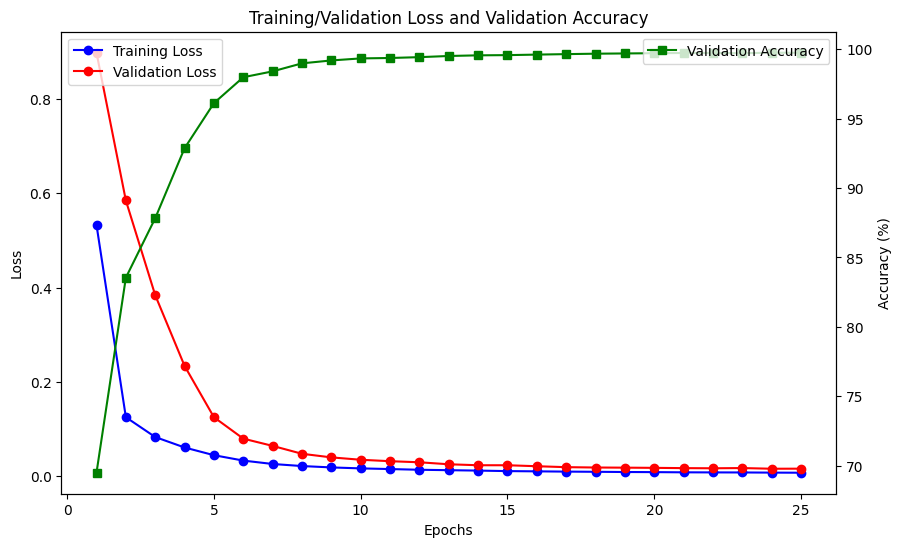

In [11]:
plot_metrics(train_losses, val_losses, val_accuracies)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00    418042
             Bot       0.00      0.00      0.00       397
            DDoS       1.00      1.00      1.00     25752
   DoS GoldenEye       0.99      0.93      0.96      2051
        DoS Hulk       1.00      1.00      1.00     45685
DoS Slowhttptest       0.83      0.97      0.90      1089
   DoS slowloris       0.95      0.94      0.95      1102
     FTP-Patator       1.00      0.99      0.99      1610
      Heartbleed       0.00      0.00      0.00         1
    Infiltration       0.00      0.00      0.00        11
        PortScan       0.99      1.00      0.99     31483
     SSH-Patator       0.91      0.99      0.95      1161

        accuracy                           1.00    528384
       macro avg       0.72      0.74      0.73    528384
    weighted avg       1.00      1.00      1.00    528384



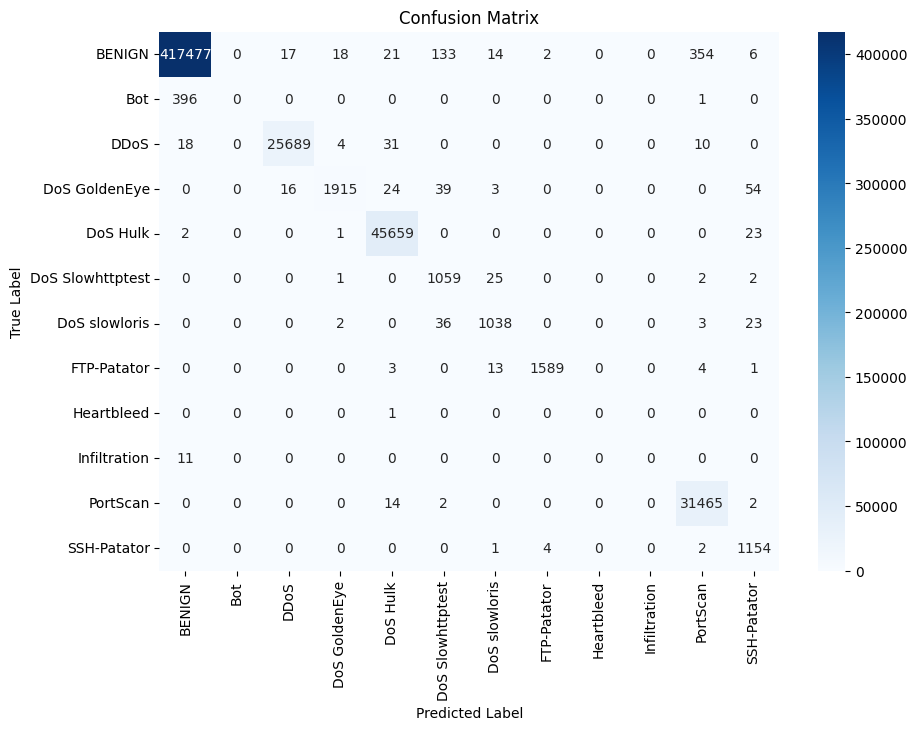

In [12]:
detailed_metrics(trained_model, test_loader)